<a href="https://colab.research.google.com/github/catalinaMaria1/TemaIA/blob/main/Varianta_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Cel mai bun k găsit prin CV este: k = 7

 Rezultate - kNN Optimizat (k=7)
--------------------------------------
Accuracy : 0.8548
Precision: 0.8947
Recall   : 0.9444
F1 Score : 0.9189
ROC-AUC  : 0.8715


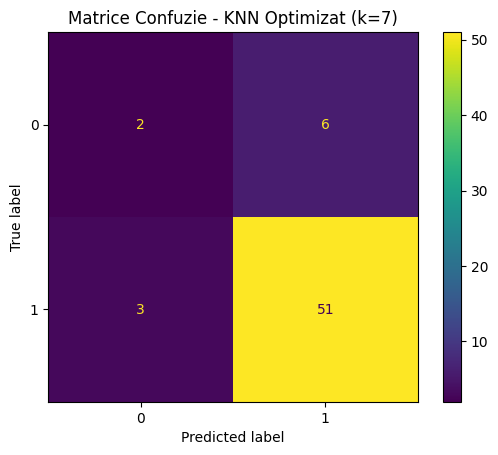

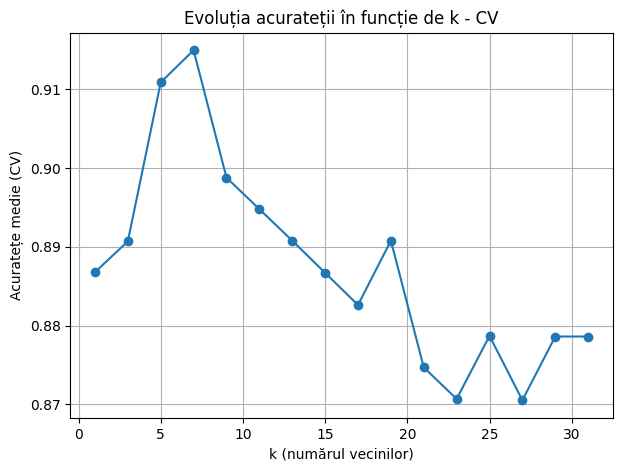

In [2]:

# KNN Optimizat (CV 5-Fold)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

# Încărcare dataset
df = pd.read_csv('survey lung cancer.csv')

# Curățare
df.columns = df.columns.str.strip()
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'YES': 1, 'NO': 0})
df = df.dropna().reset_index(drop=True)

binary_cols = ['SMOKING','YELLOW_FINGERS','ANXIETY','PEER_PRESSURE',
               'CHRONIC DISEASE','FATIGUE','ALLERGY','WHEEZING',
               'ALCOHOL CONSUMING','COUGHING','SHORTNESS OF BREATH',
               'SWALLOWING DIFFICULTY','CHEST PAIN']

for col in binary_cols:
    df[col] = df[col].replace({1:0, 2:1})

X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

categorical_cols = ['GENDER']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Căutăm cel mai bun k prin Cross-Validation
k_values = list(range(1, 32, 2))
cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = Pipeline([
        ('preprocess', preprocess),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
print(f" Cel mai bun k găsit prin CV este: k = {best_k}")

# Antrenare cu k optim
knn_cv = Pipeline([
    ('preprocess', preprocess),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
knn_cv.fit(X_train, y_train)

# Evaluare
y_pred = knn_cv.predict(X_test)
y_prob = knn_cv.predict_proba(X_test)[:,1]

print(f"\n Rezultate - kNN Optimizat (k={best_k})")
print("--------------------------------------")
print("Accuracy :", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("Recall   :", round(recall_score(y_test, y_pred),4))
print("F1 Score :", round(f1_score(y_test, y_pred),4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_prob),4))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Matrice Confuzie - KNN Optimizat (k={best_k})")
plt.show()

#  Grafic Acuratețe vs k
plt.figure(figsize=(7,5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("k (numărul vecinilor)")
plt.ylabel("Acuratețe medie (CV)")
plt.title("Evoluția acurateții în funcție de k - CV")
plt.grid(True)
plt.show()
